In [2]:
pip install pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 9.3 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 10.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 14.3 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 11.8 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
import numpy as np

# Define directories
input_dir = "MobiFall"  # Main dataset folder
cleaned_dir = "MobiFall_Cleaned"  # Folder for cleaned files
os.makedirs(cleaned_dir, exist_ok=True)

# Function to clean each dataset
def clean_dataset(file_path, save_path):
    try:
        # Read TXT file as DataFrame (assuming space-separated values)
        df = pd.read_csv(file_path, sep=" ", header=None, engine="python")

        print(f"\n🔹 Processing file: {os.path.basename(file_path)}")

        # Initial number of rows
        initial_rows = df.shape[0]
        print(f"📌 Initial number of rows: {initial_rows}")
        print("📌 Original Data Sample:\n", df.head(), "\n")

        ### 1️⃣ Handling Missing Values ###
        missing_values_before = df.isnull().sum().sum()
        print(f"🔍 Missing values before: {missing_values_before}")

        # Fill numerical columns with median, categorical with mode
        for col in df.columns:
            if df[col].dtype == 'O':  # Categorical
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:  # Numerical
                df[col].fillna(df[col].median(), inplace=True)

        missing_values_after = df.isnull().sum().sum()
        print(f"✅ Missing values after: {missing_values_after}")
        print("📌 Data After Handling Missing Values:\n", df.head(), "\n")

        ### 2️⃣ Removing Redundant Values (Duplicates) ###
        duplicate_rows = df.duplicated().sum()
        print(f"🔍 Duplicate rows found: {duplicate_rows}")
        df.drop_duplicates(inplace=True)
        after_duplicate_rows = df.shape[0]
        print(f"✅ Rows after duplicate removal: {after_duplicate_rows}")
        print("📌 Data After Removing Duplicates:\n", df.head(), "\n")

        ### 3️⃣ Fixing Structural Errors (Trimming & Lowercasing) ###
        df = df.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)
        print("📌 Data After Fixing Structural Errors:\n", df.head(), "\n")

        ### 4️⃣ Handling Outliers (IQR Method) ###
        outliers_removed = 0
        for col in df.select_dtypes(include=[np.number]).columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            before_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
            outliers_removed += before_outliers
            
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        after_outliers_rows = df.shape[0]
        print(f"🔍 Outliers removed: {outliers_removed}")
        print(f"✅ Rows after outlier removal: {after_outliers_rows}")
        print("📌 Data After Removing Outliers:\n", df.head(), "\n")

        ### 5️⃣ Data Imputation (Re-check for missing values) ###
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype == 'O':
                    df[col].fillna(df[col].mode()[0], inplace=True)
                else:
                    df[col].fillna(df[col].median(), inplace=True)

        ### 6️⃣ Removing Unwanted Observations ###
        before_removal = df.shape[0]
        df = df[~df.apply(lambda row: row.astype(str).str.contains("unknown|error", case=False).any(), axis=1)]
        removed_obs = before_removal - df.shape[0]
        after_removal_rows = df.shape[0]
        print(f"🔍 Unwanted observations removed: {removed_obs}")
        print(f"✅ Rows after removing unwanted observations: {after_removal_rows}")
        print("📌 Data After Removing Unwanted Observations:\n", df.head(), "\n")

        # Final row count
        final_rows = df.shape[0]
        print(f"📌 Final number of rows: {final_rows} (Rows Removed: {initial_rows - final_rows})")

        # Save cleaned data
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_csv(save_path, sep=" ", index=False, header=False)

        print(f"✅ Cleaned data saved: {save_path}")

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")

# Traverse MobiFall directories and clean all text files
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".txt"):
            input_path = os.path.join(root, file)
            relative_path = os.path.relpath(input_path, input_dir)  # Preserve directory structure
            output_path = os.path.join(cleaned_dir, relative_path)
            clean_dataset(input_path, output_path)

print("\n✅ Data cleaning completed for all MobiFall files.")


❌ Error processing MobiFall/Readme.txt: Expected 1 fields in line 16, saw 2

🔹 Processing file: FOL_gyro_10_2.txt
📌 Initial number of rows: 2013
📌 Original Data Sample:
                                            0           1         2       3   \
0                                       #Rate          of  rotation  around   
1                 #timestamp(ns),x,y,z(rad/s)        None      None    None   
2                                  #Datetime:  05/07/2013  10:46:11    None   
3  ##########################################        None      None    None   
4                                  #Activity:          10         -     FOL   

     4     5        6      7     8         9           10  
0   the     x        y      z  axes  (Angular  velocity).  
1  None  None     None   None  None      None        None  
2  None  None     None   None  None      None        None  
3  None  None     None   None  None      None        None  
4     -  Fall  forward  lying     -       10s        No

In [1]:
pip install matplotlib seaborn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 14.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Visualization settings
# sns.set(style="whitegrid")

# # Helper function to load data from a file
# def load_data(file_path):
#     try:
#         return pd.read_csv(file_path, header=None, delimiter=r"\s+")
#     except Exception as e:
#         print(f"Error loading file {file_path}: {e}")
#         return None

# # 1. Harth_Cleaned Visualizations (only for specific files)
# def visualize_harth_cleaned(data_dir):
#     files = ['S008.txt', 'S010.txt', 'S015.txt']  # Selected files
#     for file in files:
#         file_path = os.path.join(data_dir, file)
#         data = load_data(file_path)

#         if data is not None:
#             # Line plot for accelerometer data (X, Y, Z)
#             plt.figure(figsize=(12, 6))
#             data.plot()
#             plt.title(f'Line Plot of Accelerometer Data from {file}')
#             plt.xlabel('Time')
#             plt.ylabel('Accelerometer readings')
#             plt.legend(['X', 'Y', 'Z'])
#             plt.show()

#             # Histogram for each axis (X, Y, Z)
#             plt.figure(figsize=(12, 6))
#             data.hist(bins=30)
#             plt.title(f'Histogram of Accelerometer Data from {file}')
#             plt.xlabel('Accelerometer readings')
#             plt.ylabel('Frequency')
#             plt.legend(['X', 'Y', 'Z'])
#             plt.show()

#             # Boxplot for each axis (X, Y, Z)
#             plt.figure(figsize=(12, 6))
#             sns.boxplot(data=data)
#             plt.title(f'Boxplot of Accelerometer Data from {file}')
#             plt.xlabel('Axes')
#             plt.ylabel('Accelerometer readings')
#             plt.show()

# # 2. Harus_Cleaned Visualizations (only for selected data)
# def visualize_harus_cleaned(train_dir):
#     # Load specific training data
#     total_acc_x_train = load_data(os.path.join(train_dir, 'Inertial Signals', 'total_acc_x_train.txt'))
#     total_acc_z_train = load_data(os.path.join(train_dir, 'Inertial Signals', 'total_acc_z_train.txt'))
#     subject_train = load_data(os.path.join(train_dir, 'subject_train.txt'))
#     y_train = load_data(os.path.join(train_dir, 'y_train.txt'))

#     if y_train is not None:
#         # Check if 'Activity' column exists, otherwise inspect the data
#         print(f"Columns in y_train: {y_train.columns}")
#         if 'Activity' not in y_train.columns:
#             # Check if the file is structured differently and needs reformatting
#             print("No 'Activity' column found. Inspecting data.")
#             print(y_train.head())  # Print the first few rows to see its structure
#             # If it's just a single column with activity labels, we'll rename the column
#             y_train.columns = ['Activity']  # Rename the column to 'Activity' if it's missing

#         # Histogram for activity labels (only top 3 activities)
#         activity_count = y_train['Activity'].value_counts().sort_index()
#         top_activities = activity_count.head(3)  # Select top 3 activities
        
#         plt.figure(figsize=(8, 6))
#         sns.barplot(x=top_activities.index, y=top_activities.values, palette="viridis")
#         plt.title('Top 3 Activity Distribution (Train Set)')
#         plt.xlabel('Activity')
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)
#         plt.show()

#     if total_acc_x_train is not None and total_acc_z_train is not None:
#         # Line plot for accelerometer data (X and Z axes)
#         plt.figure(figsize=(12, 6))
#         total_acc_x_train.plot(label='Total Acc X')
#         total_acc_z_train.plot(label='Total Acc Z')
#         plt.title('Line Plot of Accelerometer Data (Train Set)')
#         plt.xlabel('Time')
#         plt.ylabel('Acceleration')
#         plt.legend()
#         plt.show()

#         # Boxplot for accelerometer data (X and Z axes)
#         plt.figure(figsize=(12, 6))
#         sns.boxplot(data=[total_acc_x_train.values.flatten(), total_acc_z_train.values.flatten()])
#         plt.title('Boxplot of Accelerometer Data (Train Set)')
#         plt.xticks([0, 1], ['X Axis', 'Z Axis'])
#         plt.ylabel('Accelerometer readings')
#         plt.show()

# # 3. MobiFall_Cleaned Visualizations (only for specific fall types)
# def visualize_mobifall_cleaned(data_dir):
#     subject_dirs = ['sub1', 'sub2']  # Only selected subjects (sub1, sub2)
    
#     fall_types = ['BSC', 'FOL']  # Only selected fall types (BSC and FOL)
    
#     for subject in subject_dirs:
#         subject_dir = os.path.join(data_dir, subject, 'FALLS')
        
#         # For each fall type (BSC, FOL), load accelerometer data
#         for fall_type in fall_types:
#             fall_dir = os.path.join(subject_dir, fall_type)
            
#             if os.path.exists(fall_dir):
#                 files = [f for f in os.listdir(fall_dir) if f.endswith('.txt')]
                
#                 for file in files:
#                     file_path = os.path.join(fall_dir, file)
#                     data = load_data(file_path)

#                     if data is not None:
#                         # Line Plot for accelerometer or gyroscope data
#                         if 'acc' in file:
#                             plt.figure(figsize=(12, 6))
#                             data.plot()
#                             plt.title(f'{fall_type} Accelerometer Data - {file}')
#                             plt.xlabel('Time')
#                             plt.ylabel('Accelerometer readings')
#                             plt.legend(['X', 'Y', 'Z'])
#                             plt.show()
#                         elif 'gyro' in file:
#                             plt.figure(figsize=(12, 6))
#                             data.plot()
#                             plt.title(f'{fall_type} Gyroscope Data - {file}')
#                             plt.xlabel('Time')
#                             plt.ylabel('Gyroscope readings')
#                             plt.legend(['X', 'Y', 'Z'])
#                             plt.show()

#                         # Histogram for accelerometer data (X, Y, Z)
#                         if 'acc' in file:
#                             plt.figure(figsize=(12, 6))
#                             data.hist(bins=30)
#                             plt.title(f'{fall_type} Histogram of Accelerometer Data - {file}')
#                             plt.xlabel('Accelerometer readings')
#                             plt.ylabel('Frequency')
#                             plt.legend(['X', 'Y', 'Z'])
#                             plt.show()

#                         # Boxplot for accelerometer or gyroscope data
#                         if 'acc' in file:
#                             plt.figure(figsize=(12, 6))
#                             sns.boxplot(data=data)
#                             plt.title(f'{fall_type} Boxplot of Accelerometer Data - {file}')
#                             plt.xlabel('Axes')
#                             plt.ylabel('Accelerometer readings')
#                             plt.show()

# # Main function to call visualizations for each dataset
# def main():
#     # Visualizations for Harth_Cleaned
#     print("Visualizing Harth_Cleaned...")
#     visualize_harth_cleaned('Harth_Cleaned')
    
#     # Visualizations for Harus_Cleaned
#     print("Visualizing Harus_Cleaned...")
#     visualize_harus_cleaned('Harus_Cleaned/train')
    
#     # Visualizations for MobiFall_Cleaned
#     print("Visualizing MobiFall_Cleaned...")
#     visualize_mobifall_cleaned('MobiFall_Cleaned')

# # Run the main function
# if __name__ == "__main__":
#     main()


Visualizing Harth_Cleaned...


<Figure size 1200x600 with 0 Axes>

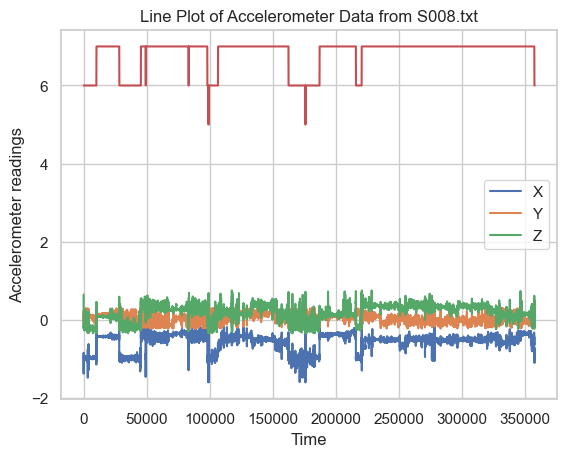

<Figure size 1200x600 with 0 Axes>

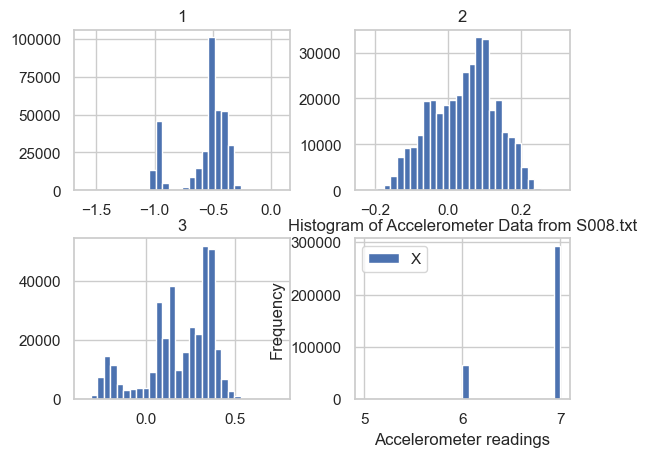

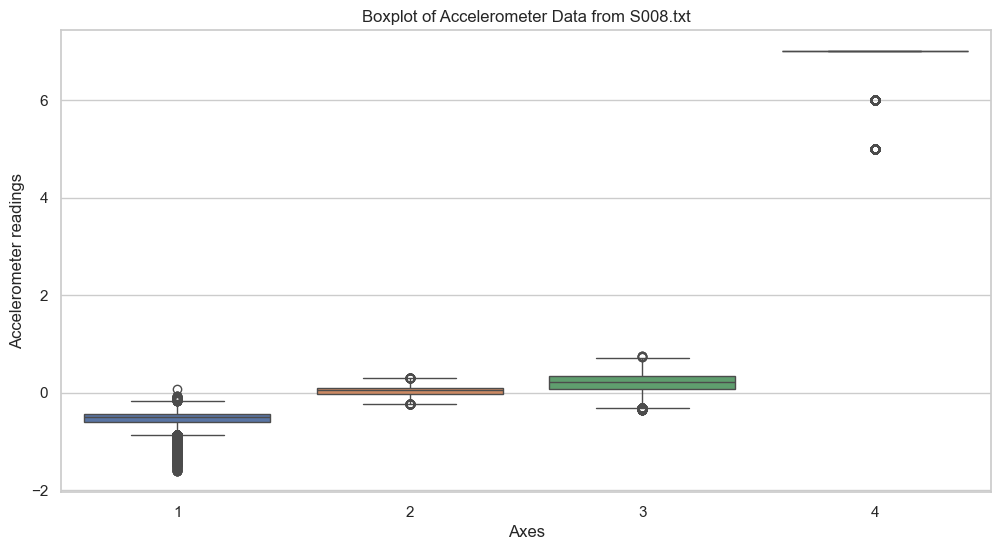

<Figure size 1200x600 with 0 Axes>

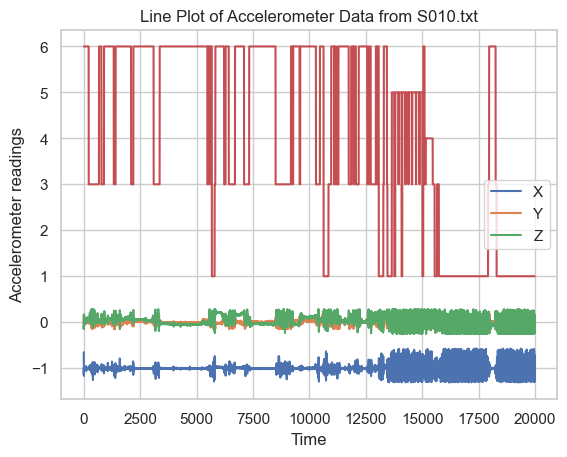

<Figure size 1200x600 with 0 Axes>

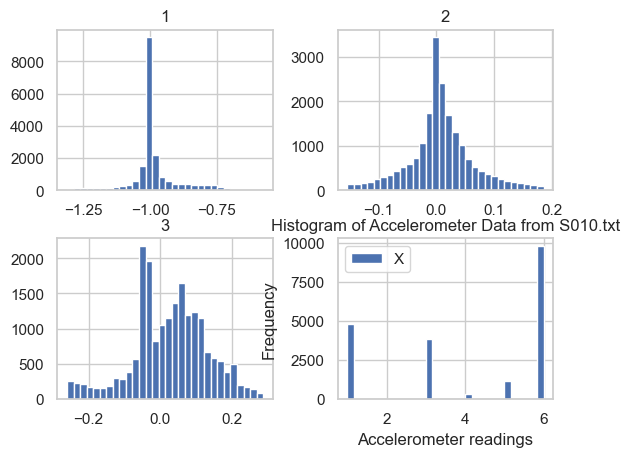

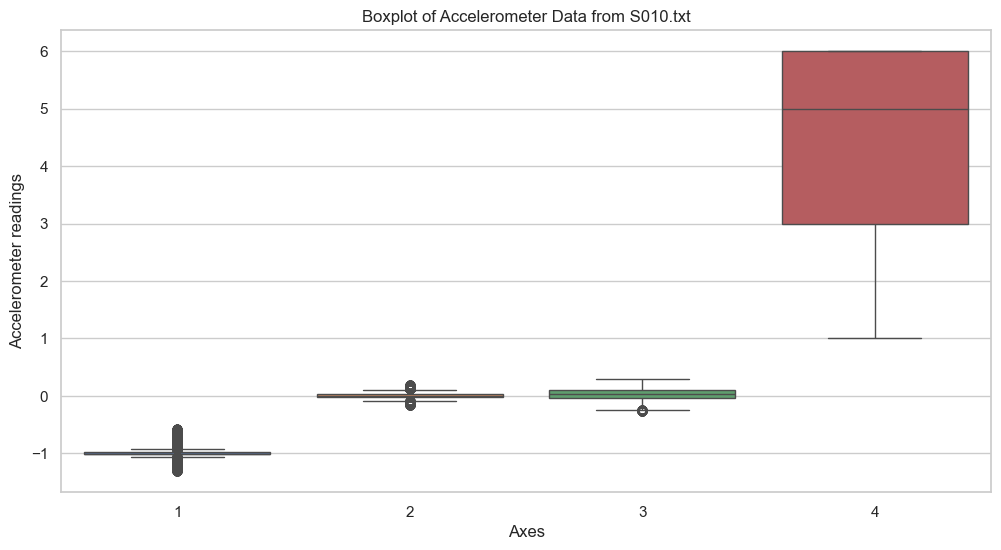

<Figure size 1200x600 with 0 Axes>

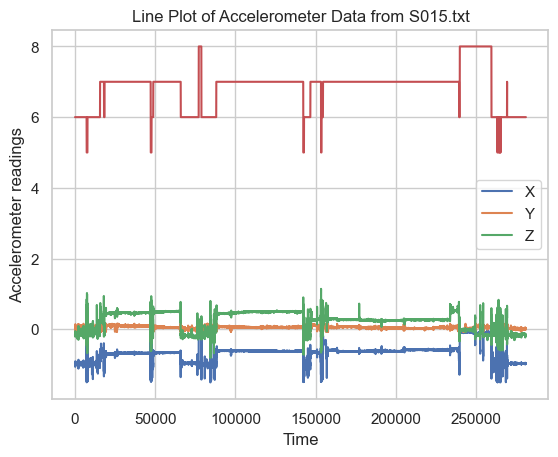

<Figure size 1200x600 with 0 Axes>

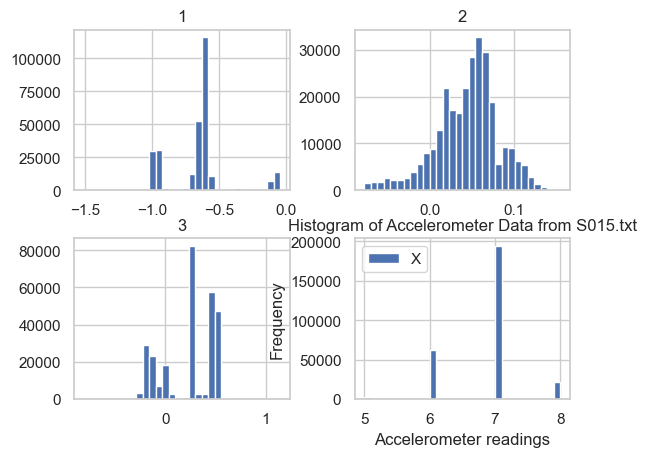

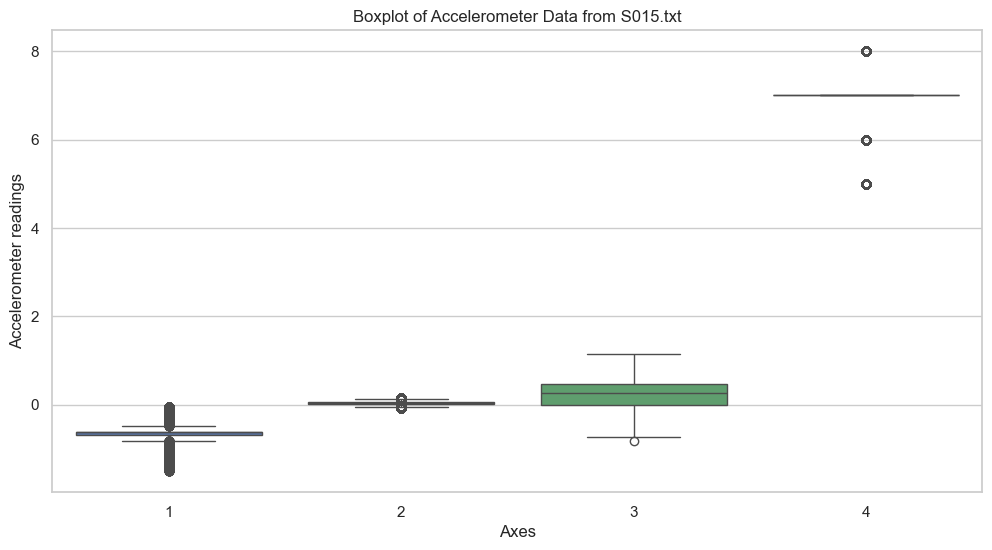

Visualizing Harus_Cleaned...
Columns in y_train: Index([0], dtype='int64')
No 'Activity' column found. Inspecting data.
   0
0  5
1  4
2  6
3  1
4  3


/var/folders/g8/q_w7xsk949l0v_g2pg_1m7h80000gn/T/ipykernel_24931/3006142545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_activities.index, y=top_activities.values, palette="viridis")


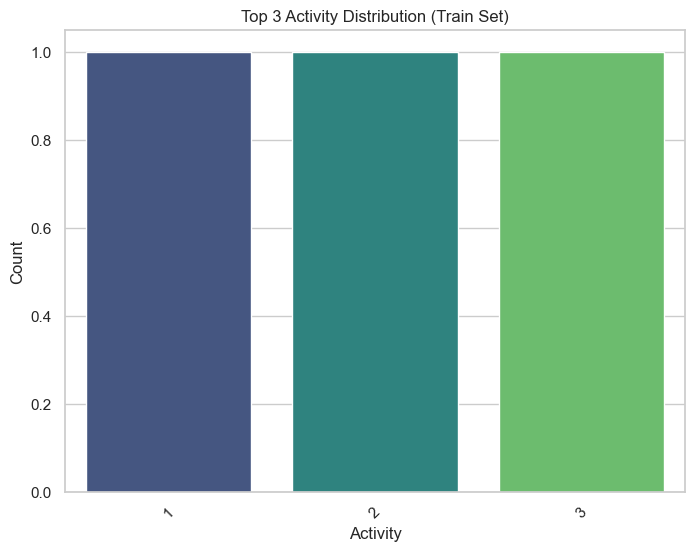

<Figure size 1200x600 with 0 Axes>

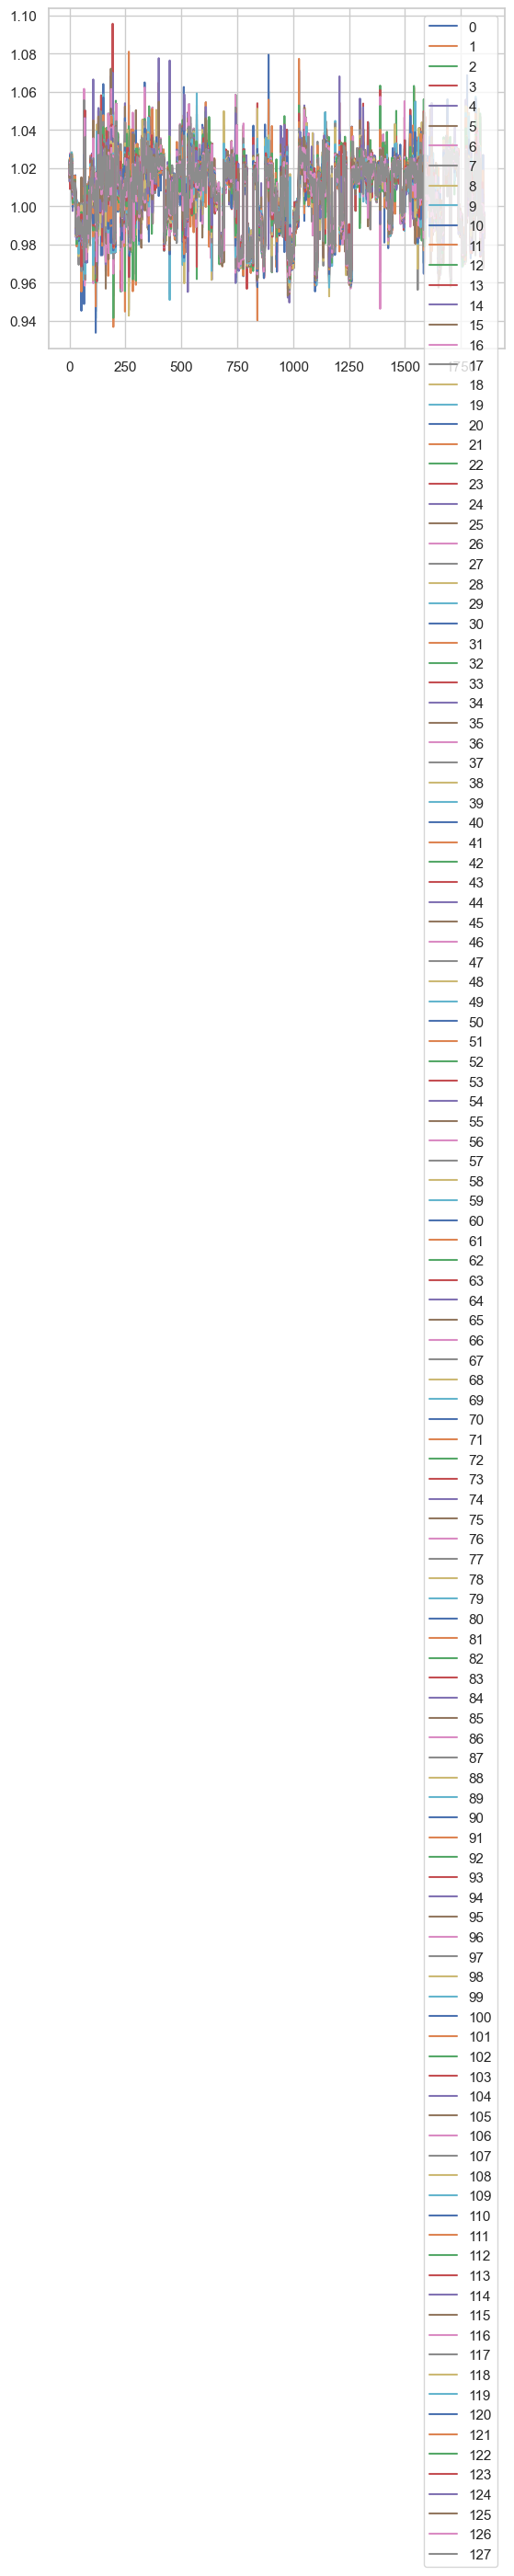

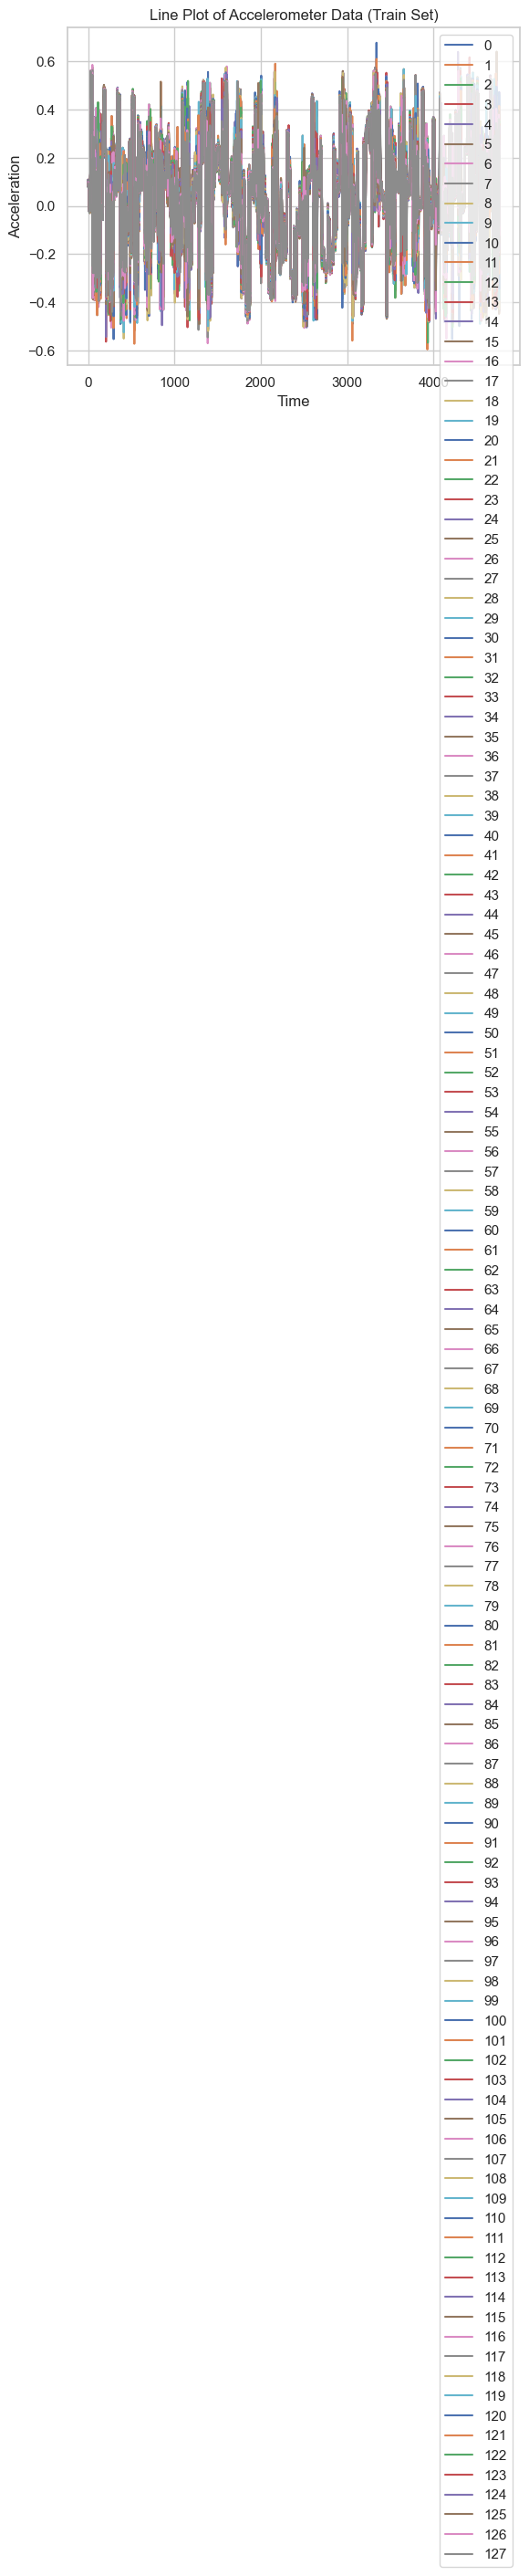

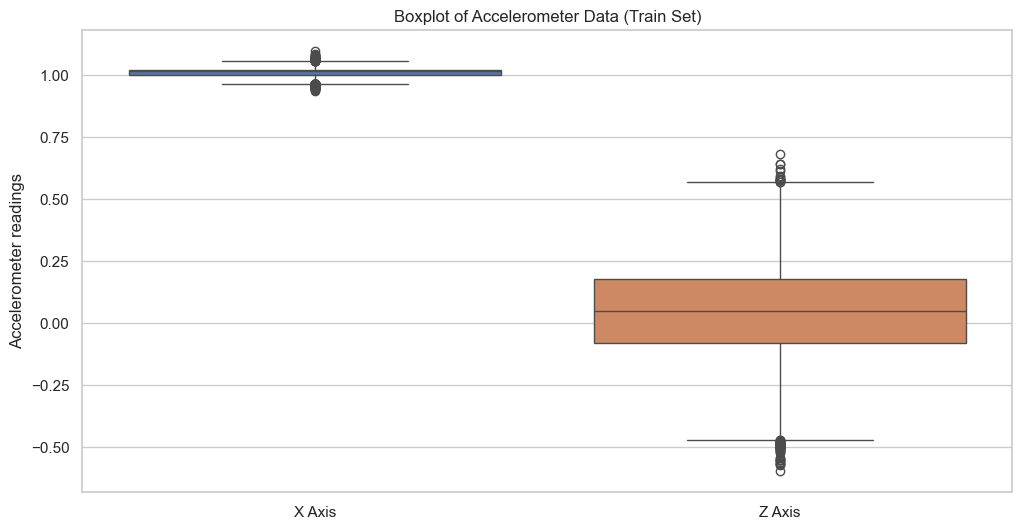

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set(style="whitegrid")

# Helper function to load data from a file
def load_data(file_path):
    try:
        return pd.read_csv(file_path, header=None, delimiter=r"\s+")
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

# 1. Harth_Cleaned Visualizations (only for specific files)
def visualize_harth_cleaned(data_dir):
    files = ['S008.txt', 'S010.txt', 'S015.txt']  # Selected files
    for file in files:
        file_path = os.path.join(data_dir, file)
        data = load_data(file_path)

        if data is not None:
            # Line plot for accelerometer data (X, Y, Z)
            plt.figure(figsize=(12, 6))
            data.plot()
            plt.title(f'Line Plot of Accelerometer Data from {file}')
            plt.xlabel('Time')
            plt.ylabel('Accelerometer readings')
            plt.legend(['X', 'Y', 'Z'])
            plt.show()

            # Histogram for each axis (X, Y, Z)
            plt.figure(figsize=(12, 6))
            data.hist(bins=30)
            plt.title(f'Histogram of Accelerometer Data from {file}')
            plt.xlabel('Accelerometer readings')
            plt.ylabel('Frequency')
            plt.legend(['X', 'Y', 'Z'])
            plt.show()

            # Boxplot for each axis (X, Y, Z)
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=data)
            plt.title(f'Boxplot of Accelerometer Data from {file}')
            plt.xlabel('Axes')
            plt.ylabel('Accelerometer readings')
            plt.show()

# 2. Harus_Cleaned Visualizations (only for selected data)
def visualize_harus_cleaned(train_dir):
    # Load specific training data
    total_acc_x_train = load_data(os.path.join(train_dir, 'Inertial Signals', 'total_acc_x_train.txt'))
    total_acc_z_train = load_data(os.path.join(train_dir, 'Inertial Signals', 'total_acc_z_train.txt'))
    subject_train = load_data(os.path.join(train_dir, 'subject_train.txt'))
    y_train = load_data(os.path.join(train_dir, 'y_train.txt'))

    if y_train is not None:
        # Check if 'Activity' column exists, otherwise inspect the data
        print(f"Columns in y_train: {y_train.columns}")
        if 'Activity' not in y_train.columns:
            # Check if the file is structured differently and needs reformatting
            print("No 'Activity' column found. Inspecting data.")
            print(y_train.head())  # Print the first few rows to see its structure
            # If it's just a single column with activity labels, we'll rename the column
            y_train.columns = ['Activity']  # Rename the column to 'Activity' if it's missing

        # Histogram for activity labels (only top 3 activities)
        activity_count = y_train['Activity'].value_counts().sort_index()
        top_activities = activity_count.head(3)  # Select top 3 activities
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=top_activities.index, y=top_activities.values, palette="viridis")
        plt.title('Top 3 Activity Distribution (Train Set)')
        plt.xlabel('Activity')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

    if total_acc_x_train is not None and total_acc_z_train is not None:
        # Line plot for accelerometer data (X and Z axes)
        plt.figure(figsize=(12, 6))
        total_acc_x_train.plot(label='Total Acc X')
        total_acc_z_train.plot(label='Total Acc Z')
        plt.title('Line Plot of Accelerometer Data (Train Set)')
        plt.xlabel('Time')
        plt.ylabel('Acceleration')
        plt.legend()
        plt.show()

        # Boxplot for accelerometer data (X and Z axes)
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=[total_acc_x_train.values.flatten(), total_acc_z_train.values.flatten()])
        plt.title('Boxplot of Accelerometer Data (Train Set)')
        plt.xticks([0, 1], ['X Axis', 'Z Axis'])
        plt.ylabel('Accelerometer readings')
        plt.show()

# Main function to call visualizations for each dataset
def main():
    # Visualizations for Harth_Cleaned
    print("Visualizing Harth_Cleaned...")
    visualize_harth_cleaned('Harth_Cleaned')
    
    # Visualizations for Harus_Cleaned
    print("Visualizing Harus_Cleaned...")
    visualize_harus_cleaned('Harus_Cleaned/train')

# Run the main function
if __name__ == "__main__":
    main()